In [14]:
# import numpy as np
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # Load and preprocess your dataset
# data = pd.read_csv('traffic_data_large.csv')  # Replace with your dataset file

# # Features and target
# X = data[['speed', 'vehicle_count', 'distance']]  # Example features
# y = data['traffic_density']  # Target variable

# # Normalize features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Build the model
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')  # Output layer for density prediction
# ])

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Train the model
# model.fit(X_train, y_train, epochs=1, batch_size=10, validation_split=0.2)

# # Save the trained model
# model.save('traffic_density_model.h5')


In [15]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight

# Load and preprocess your dataset
data = pd.read_csv('traffic_data_large.csv')  # Replace with your dataset file

# Features and target with additional feature engineering
data['congestion_level'] = data['vehicle_count'] / (data['speed'] + 1e-5)  # Avoid division by zero
X = data[['speed', 'vehicle_count', 'distance', 'congestion_level']]
y = data['traffic_density']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a threshold for binary classification
threshold = y_train.mean()  # Adjust threshold if needed
y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_binary), y=y_train_binary)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Build a new model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model with class weights
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and class weights
model.fit(X_train, y_train_binary, epochs=30, batch_size=16, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])

# Predict on the test set
y_pred = model.predict(X_test).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print(f'Adjusted Accuracy: {accuracy:.4f}')
print(f'Adjusted Precision: {precision:.4f}')
print(f'Adjusted Recall: {recall:.4f}')
print(f'Adjusted F1 Score: {f1:.4f}')

# Save the updated model
model.save('adjusted_traffic_density_model.h5')


Epoch 1/30
20/20 [==============================] - 1s 12ms/step - loss: 0.6958 - accuracy: 0.4531 - val_loss: 0.7059 - val_accuracy: 0.4125
Epoch 2/30
20/20 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4875 - val_loss: 0.7023 - val_accuracy: 0.4125
Epoch 3/30
20/20 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5406 - val_loss: 0.7021 - val_accuracy: 0.3750
Epoch 4/30
20/20 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5250 - val_loss: 0.7010 - val_accuracy: 0.4375
Epoch 5/30
20/20 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5406 - val_loss: 0.7011 - val_accuracy: 0.4000
Epoch 6/30
20/20 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5406 - val_loss: 0.7008 - val_accuracy: 0.4125
Epoch 7/30
20/20 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5469 - val_loss: 0.6985 - val_accuracy: 0.4750
Epoch 8/30
20/20 [=

c:\Users\abhi1\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Accuracy (0.5500): The model correctly predicted traffic density as either high or low 55% of the time. Since this is close to random chance (50%), it suggests that the model may need further tuning, additional features, or a different architecture to improve general accuracy.

#Precision (0.5287): Precision of around 53% means that, when the model predicts high traffic density, it is correct about 53% of the time. This relatively low precision suggests the model may be prone to some false positives—instances where the model predicts high traffic density incorrectly.

#Recall (0.9200): The recall is very high at 92%, meaning that the model correctly identifies 92% of the actual high traffic density instances. This indicates the model is effective at capturing most high traffic situations but might be biased toward predicting high traffic too often.

#F1 Score (0.6715): The F1 score, a balance between precision and recall, is 67%. This score suggests a reasonable performance where the model is capturing most high traffic events but with trade-offs in precision.

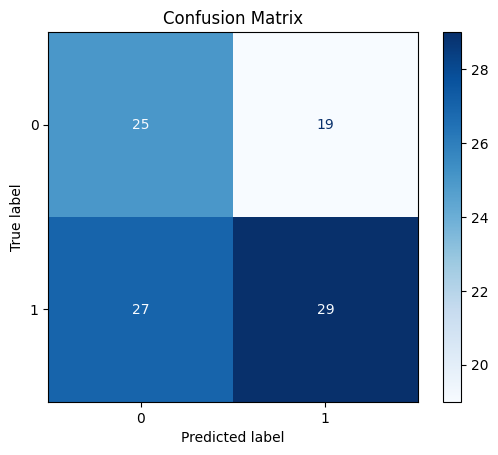

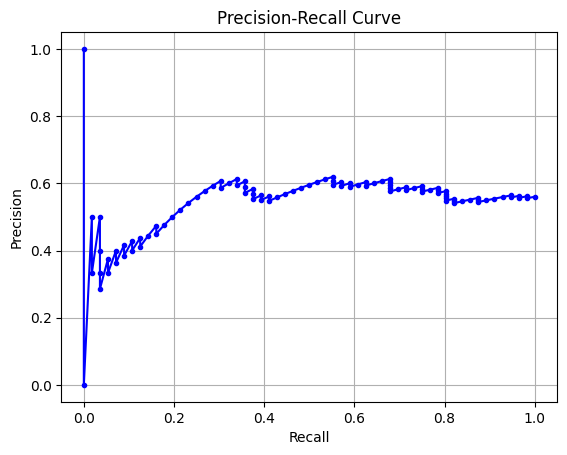

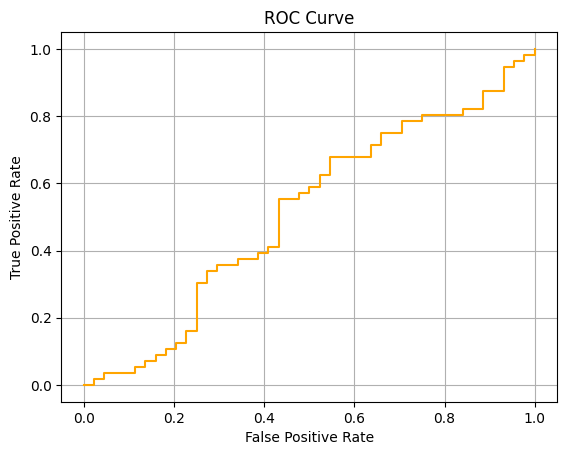

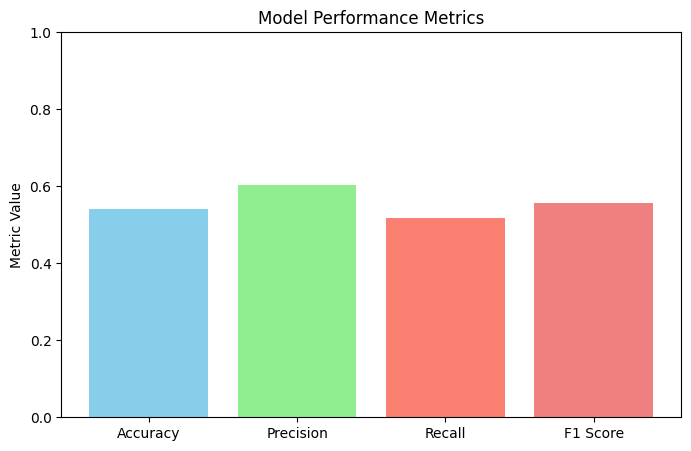

In [16]:
# Import necessary libraries for visualizations
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Sample ground truth and predictions for demonstration purposes
np.random.seed(42)
y_test_binary = np.random.randint(0, 2, 100)  # True labels (binary)
y_pred_probabilities = np.random.rand(100)  # Predicted probabilities (for precision-recall and ROC curve)

# Threshold for binary classification
y_pred_binary = (y_pred_probabilities > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 1. Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 2. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test_binary, y_pred_probabilities)
plt.plot(recall_vals, precision_vals, marker='.', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_probabilities)
plt.plot(fpr, tpr, color='orange', label=f'AUC')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# 4. Bar Plot for Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Metric Value")
plt.show()
